In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import inspect
import scipy
from scipy.stats import entropy

In [148]:
config = {"input_size" : 784,
          "hidden_layer1" : 512,
          "hidden_layer2" : 256,
          "bottleneck" : 128,
          "hidden_layer3" : 256,
          "hidden_layer4" : 512,
          "learning_rate" : 0.001,
          "number_epoch" : 100,
          "batch_size" : 100,
          "eps": 1e-12
          }

In [3]:
transformation = transforms.Compose([transforms.ToTensor()])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transformation, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformation, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config["batch_size"], shuffle=False)

In [516]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size=config["input_size"], hidden_layer1=config["hidden_layer1"], hidden_layer2=config["hidden_layer2"], bottleneck=config["bottleneck"], hidden_layer3=config["hidden_layer3"], hidden_layer4=config["hidden_layer4"]):
        super(VariationalAutoencoder, self).__init__()

        self.encoding_layers = nn.Sequential(
            nn.Linear(input_size, hidden_layer1),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer2, bottleneck),
        )

        self.mew = nn.Linear(bottleneck, bottleneck)
        self.logvar = nn.Linear(bottleneck, bottleneck)

        self.decoding_layers = nn.Sequential(
            nn.Linear(bottleneck, hidden_layer3),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer3, hidden_layer4),
            nn.LeakyReLU(),
            nn.Linear(hidden_layer4, input_size)
        )  
    def encoder_forward(self, data_vector):
        # make some error handling here later hopefully 
        # q_phi(z|x) is what we want to calculate here, we assume q_phi(z|x) is a from a normal
        # we must find mew and sigma^2 for the normal 
        # to find the following we take the data vector and put in its latent representation  
        # q_phi(z|x) is approximatly N_phi(z|x) with paramters mew and sigma as phi

        encoder_output = self.encoding_layers(data_vector)
        mew = self.mew(encoder_output)
        logvar = self.logvar(encoder_output)

        return mew, logvar

    def decoder_forward(self, mew, logvar):
        #z = u + sigma * eita^i
        #eita ~ N(0, 1)
        # 100 by 128 
        
        eps = torch.randn((config['batch_size'], config['bottleneck']))
        logvar = 0.5 * logvar
        
        z = mew + torch.exp(logvar) * eps
        
        decoder_output = self.decoding_layers(z)

        return decoder_output


In [537]:
def Elbo(data_vector, output_vector, mew, logvar):
    L_2 = F.mse_loss(data_vector, output_vector, reduction="sum")/  config['batch_size']
    
    KL = (-0.5 * torch.sum(1 + logvar - mew**2 - torch.exp(logvar))) / config['batch_size']
    
    loss = KL + L_2

    return loss 
    

In [ ]:
Model = VariationalAutoencoder()
sig = inspect.signature(VariationalAutoencoder.__init__)
keys_list = [key for key in sig.parameters.keys() if key != 'self']
Model = VariationalAutoencoder(*[config[key] for key in keys_list])
optimizer = optim.Adam(Model.parameters(), lr=1e-3)
losses = []
new_avg_loss = 0
for epoch in range(config["number_epoch"]):
    epoch_loss = []
    for (i, (image_matrix, label) )in enumerate(train_loader):       
        #Forward pass
        image_vector = image_matrix.reshape(-1, config["input_size"])
        image_vector = image_vector.type(torch.float32)

        mew, sigma = Model.encoder_forward(image_vector)

        reconstructed_image = Model.decoder_forward(mew, sigma)

        loss = Elbo(image_vector, reconstructed_image, mew, sigma)
        losses.append(loss.item())
        epoch_loss.append(loss.item())
        
        #backpropogation

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        avg_loss = sum(epoch_loss) / len(epoch_loss)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{config["number_epoch"]}], Avg Loss: {avg_loss:.6f}')
            convegence_check = abs(avg_loss - new_avg_loss) / max(1, new_avg_loss)  
            if convegence_check < 1e-4:
                break
            new_avg_loss = avg_loss
        
  


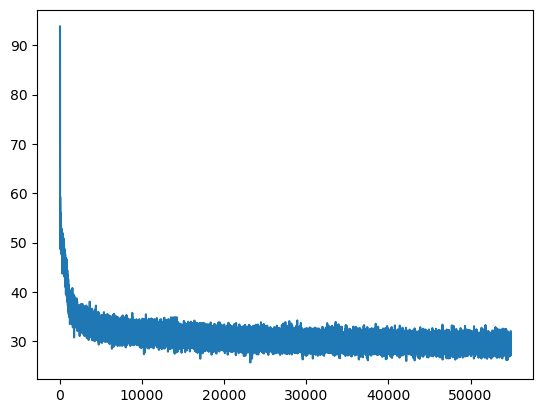

In [540]:
plt.plot(losses)

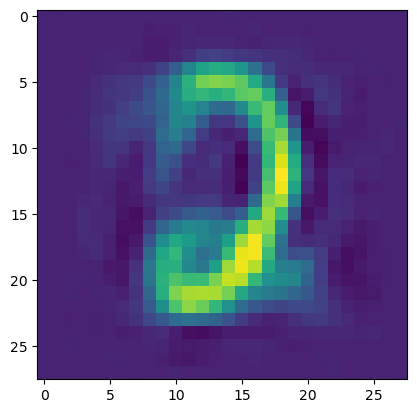

In [542]:
mu = torch.randn(1, 128)
log_var = torch.randn(1, 128)
plt.imshow(Model.decoder_forward(mu, log_var)[99].view(28, 28).detach().numpy())

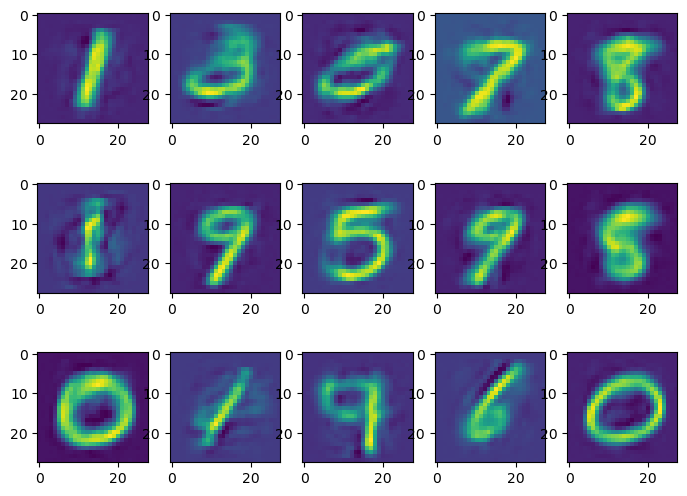

<Figure size 640x480 with 0 Axes>

In [575]:
num_graphs = 15
final_result = []
model_parameters = []
images = []
fig, ax = plt.subplots(3 ,5)
for graph in range(num_graphs):
    mu , log_var = torch.randn(1, 128), torch.randn(1, 128)
    image = Model.decoder_forward(mu, log_var)[graph].view(28, 28).detach().numpy()
    images.append(image)
for idx, img in enumerate(images):  
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx]
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove any padding
plt.show()
plt.tight_layout()